<a href="https://colab.research.google.com/github/accarter/DS-Unit-2-Kaggle-Challenge/blob/master/module2-random-forests/LS_DS_222_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 2*

---

# Random Forests

## Assignment
- [ ] Read [“Adopting a Hypothesis-Driven Workflow”](http://archive.is/Nu3EI), a blog post by a Lambda DS student about the Tanzania Waterpumps challenge.
- [ ] Continue to participate in our Kaggle challenge.
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features.
- [ ] Try Ordinal Encoding.
- [ ] Try a Random Forest Classifier.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.

## Stretch Goals

### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Do more exploratory data analysis, data cleaning, feature engineering, and feature selection.
- [ ] Try other [categorical encodings](https://contrib.scikit-learn.org/category_encoders/).
- [ ] Get and plot your feature importances.
- [ ] Make visualizations and share on Slack.

### Reading

Top recommendations in _**bold italic:**_

#### Decision Trees
- A Visual Introduction to Machine Learning, [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/),  and _**[Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)**_
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU)

#### Random Forests
- [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/), Chapter 8: Tree-Based Methods
- [Coloring with Random Forests](http://structuringtheunstructured.blogspot.com/2017/11/coloring-with-random-forests.html)
- _**[Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)**_

#### Categorical encoding for trees
- [Are categorical variables getting lost in your random forests?](https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/)
- [Beyond One-Hot: An Exploration of Categorical Variables](http://www.willmcginnis.com/2015/11/29/beyond-one-hot-an-exploration-of-categorical-variables/)
- _**[Categorical Features and Encoding in Decision Trees](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931)**_
- _**[Coursera — How to Win a Data Science Competition: Learn from Top Kagglers — Concept of mean encoding](https://www.coursera.org/lecture/competitive-data-science/concept-of-mean-encoding-b5Gxv)**_
- [Mean (likelihood) encodings: a comprehensive study](https://www.kaggle.com/vprokopev/mean-likelihood-encodings-a-comprehensive-study)
- [The Mechanics of Machine Learning, Chapter 6: Categorically Speaking](https://mlbook.explained.ai/catvars.html)

#### Imposter Syndrome
- [Effort Shock and Reward Shock (How The Karate Kid Ruined The Modern World)](http://www.tempobook.com/2014/07/09/effort-shock-and-reward-shock/)
- [How to manage impostor syndrome in data science](https://towardsdatascience.com/how-to-manage-impostor-syndrome-in-data-science-ad814809f068)
- ["I am not a real data scientist"](https://brohrer.github.io/imposter_syndrome.html)
- _**[Imposter Syndrome in Data Science](https://caitlinhudon.com/2018/01/19/imposter-syndrome-in-data-science/)**_


### More Categorical Encodings

**1.** The article **[Categorical Features and Encoding in Decision Trees](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931)** mentions 4 encodings:

- **"Categorical Encoding":** This means using the raw categorical values as-is, not encoded. Scikit-learn doesn't support this, but some tree algorithm implementations do. For example, [Catboost](https://catboost.ai/), or R's [rpart](https://cran.r-project.org/web/packages/rpart/index.html) package.
- **Numeric Encoding:** Synonymous with Label Encoding, or "Ordinal" Encoding with random order. We can use [category_encoders.OrdinalEncoder](https://contrib.scikit-learn.org/category_encoders/ordinal.html).
- **One-Hot Encoding:** We can use [category_encoders.OneHotEncoder](https://contrib.scikit-learn.org/category_encoders/onehot.html).
- **Binary Encoding:** We can use [category_encoders.BinaryEncoder](https://contrib.scikit-learn.org/category_encoders/binary.html).


**2.** The short video 
**[Coursera — How to Win a Data Science Competition: Learn from Top Kagglers — Concept of mean encoding](https://www.coursera.org/lecture/competitive-data-science/concept-of-mean-encoding-b5Gxv)** introduces an interesting idea: use both X _and_ y to encode categoricals.

Category Encoders has multiple implementations of this general concept:

- [CatBoost Encoder](https://contrib.scikit-learn.org/category_encoders/catboost.html)
- [Generalized Linear Mixed Model Encoder](https://contrib.scikit-learn.org/category_encoders/glmm.html)
- [James-Stein Encoder](https://contrib.scikit-learn.org/category_encoders/jamesstein.html)
- [Leave One Out](https://contrib.scikit-learn.org/category_encoders/leaveoneout.html)
- [M-estimate](https://contrib.scikit-learn.org/category_encoders/mestimate.html)
- [Target Encoder](https://contrib.scikit-learn.org/category_encoders/targetencoder.html)
- [Weight of Evidence](https://contrib.scikit-learn.org/category_encoders/woe.html)

Category Encoder's mean encoding implementations work for regression problems or binary classification problems. 

For multi-class classification problems, you will need to temporarily reformulate it as binary classification. For example:

```python
encoder = ce.TargetEncoder(min_samples_leaf=..., smoothing=...) # Both parameters > 1 to avoid overfitting
X_train_encoded = encoder.fit_transform(X_train, y_train=='functional')
X_val_encoded = encoder.transform(X_train, y_val=='functional')
```

For this reason, mean encoding won't work well within pipelines for multi-class classification problems.

**3.** The **[dirty_cat](https://dirty-cat.github.io/stable/)** library has a Target Encoder implementation that works with multi-class classification.

```python
 dirty_cat.TargetEncoder(clf_type='multiclass-clf')
```
It also implements an interesting idea called ["Similarity Encoder" for dirty categories](https://www.slideshare.net/GaelVaroquaux/machine-learning-on-non-curated-data-154905090).

However, it seems like dirty_cat doesn't handle missing values or unknown categories as well as category_encoders does. And you may need to use it with one column at a time, instead of with your whole dataframe.

**4. [Embeddings](https://www.kaggle.com/colinmorris/embedding-layers)** can work well with sparse / high cardinality categoricals.

_**I hope it’s not too frustrating or confusing that there’s not one “canonical” way to encode categoricals. It’s an active area of research and experimentation — maybe you can make your own contributions!**_

### Setup

You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab (run the code cell below).

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

### Data Exploration

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


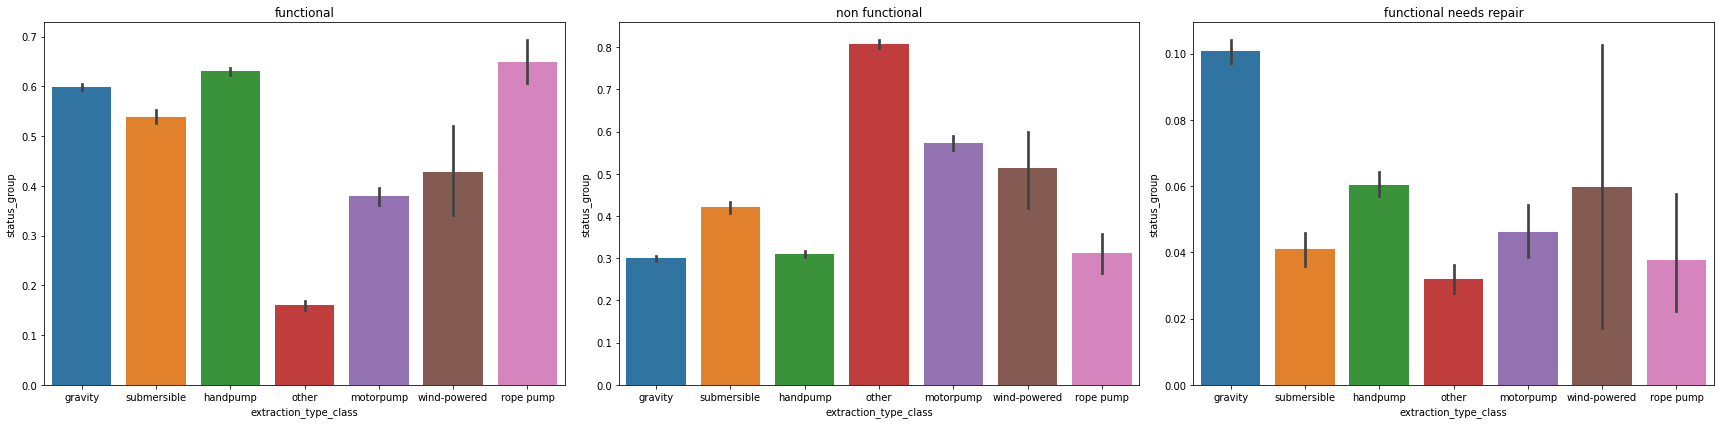

In [ ]:
target = 'status_group'
feature = 'extraction_type_class'

fig, axes = plt.subplots(1, 3, figsize=(24,6))
for label, ax in zip(train[target].unique(), axes):
  sns.barplot(
      x=train[feature],
      y=train[target] == label,
      ax=ax
  ).set_title(label);
plt.tight_layout()

### Train/Validate Split

In [ ]:
# train_raw, val_raw = train_test_split(train, test_size=0.20, train_size=0.80,
#                               random_state=42, shuffle=True, stratify=train[target])

initial_row_counts = [df.shape[0] for df in (train, test)]

def assert_initial_shape(train, test):
  '''
  Ensure that the number of rows in each DataFrame remains unchanged.
  '''
  for count, df in zip(initial_row_counts, (train, test)):
    assert count == df.shape[0]

initial_row_counts

[59400, 14358]

### Filters

In [ ]:
import numpy as np

def remove_outliers(se):
  '''
  Remove outer 1% of values (outliers).
  '''
  se = se.dropna()
  return pd.Series(np.where((se >= np.percentile(se, 0.5)) &
                            (se <= np.percentile(se, 99.5)), se, np.nan))
  

def clean(filter):
  '''
  Decorator function for casting pd.Series as type float
  and removing any outliers after applying the specified filter.
  '''
  def wrapper(se):
    return remove_outliers(filter(se.astype(float)))
  return wrapper

Population
*  Replace rows with values of 1 or less.
*  Feature engineer two categories: (a) "1 or less" and (b) "populated" if having a population of 1 or less is meaningful.

In [ ]:
def population_filter(se):
  '''
  Replaces rows with populations of 1 or fewer with np.nan.
  Replaces rows with outliers with np.nan.
  '''
  return pd.Series(np.where((se <= 1) | (se == np.nan), np.nan, se))

Total Static Head
*  Replace values less than 0.

In [ ]:
def amount_tsh_filter(se):
  '''
  Replaces total static head values less than 0 with np.nan.
  '''
  return pd.Series(np.where((se <= 0), np.nan, se))

GPS Height
*  Replace gps height values of 0 or less.

In [ ]:
def gps_height_filter(se):
  '''
  Replaces gps height values of 0 or less with np.nan.
  '''
  return pd.Series(np.where(se <= 1, np.nan, se))

Latitude & Longitude
*  Replace latitude values of -2e-08.
*  Replace longitude values of 0.0.

In [ ]:
def axis_filter(se):
  '''
  Replaces latitude values of -2e-08 with np.nan.
  Replaces longitude vales of 0.0 with np.nan.
  '''
  null_lat = se.value_counts().index[0]
  return pd.Series(np.where(se == null_lat, np.nan, se))

Construction Year
* Replace construction years of 0.

In [ ]:
def construction_year_filter(se):
  '''
  Replaces construction years of 0 with np.nan.
  '''
  return pd.Series(np.where(se == 0, np.nan, se))

Num Private
*  Replace num private values of 0 or less.

In [ ]:
def num_private_filter(se):
  '''
  Replaces num private values of 0 or less with np.nan.
  '''
  return pd.Series(np.where(se <= 0, np.nan, se))

### Replacements

In [ ]:
numeric_features = ['population', 'amount_tsh', 'gps_height', 
                    'latitude', 'longitude', 'num_private']

measurements = ['mean', 'median', 'median', 'mean', 'mean', 'mode']

filters = [population_filter, amount_tsh_filter, gps_height_filter, 
           axis_filter, axis_filter, num_private_filter]

replacement_config = dict(zip(numeric_features, zip(measurements, filters)))

measurement_funcs = {
    'mean': lambda se: se.mean(),
    'mode': lambda se: se.mode()[0],
    'median': lambda se: se.median()
}

def find_replacement(df, feature):
  measurement, filter = replacement_config[feature]
  return measurement_funcs[measurement](clean(filter)(df[feature]))

# combine DataFrames for generating replacement values
tanzania = pd.concat([train.copy(), test.copy()])
replacements = {feature: find_replacement(tanzania, feature) for feature in numeric_features}
replacements

{'amount_tsh': 250.0,
 'gps_height': 1192.0,
 'latitude': -5.879993833884067,
 'longitude': 35.15198731008472,
 'num_private': 1.0,
 'population': 319.22367730422}

In [ ]:
df = pd.DataFrame({'a': [1, 2, 3], 'b': [4, 5, 6], 'c': [7, 8, 9]})
df['a'] = pd.Series(np.where(df['a'] < 2, -10, df['a']))
df

,a,b,c
0,-10,4,7
1,2,5,8
2,3,6,9


In [ ]:
# calculate mean latitude, longitude, gps height, and population within each district code and basin

# def replace_by_location(X):
#   X = X.copy()
#   grouped_by_region = X.groupby(['district_code', 'basin'])
#   for feature in ['latitude', 'longitude', 'gps_height', 'population']:
#     X[feature] = replacement_config[feature][1](X[feature])
#     means_by_region = grouped_by_region[feature].mean()
#     for (code, basin), avg in zip(means_by_region.index, means_by_region.values):
#       mask = ((X['district_code'] == code) & 
#               (X['basin'] == basin) & 
#               (X.apply(lambda x: np.isnan(x[feature]), axis=1)))
#       print('-' * 20)
#       print(((X['district_code'] == code) & (X['basin'] == basin)).sum())
#       print(mask.sum())
#       X[feature] = pd.Series(np.where(mask, avg, X[feature]))
#   return X

### Data Wrangling

In [ ]:
def get_means_by_region(X, features=['latitude', 'longitude', 'gps_height', 'population']):
  X = X.copy()
  grouped_by_region = X.groupby(['district_code', 'basin'])
  regional_features = {}
  for feature in features:
    regional_features[feature] = {}
    X[feature] = replacement_config[feature][1](X[feature])
    means_by_region = grouped_by_region[feature].mean()
    regional_means = {}
    for (code, basin), avg in zip(means_by_region.index, means_by_region.values):
      if np.isnan(avg):
        avg = replacements[feature] # improve by getting avg by district code
      regional_means[f'{code}-{basin}'] = avg
    regional_features[feature] = regional_means
      # mask = ((X['district_code'] == code) & 
      #         (X['basin'] == basin) & 
      #         (X.apply(lambda x: np.isnan(x[feature]), axis=1)))
      # X[feature] = pd.Series(np.where(mask, avg, X[feature]))
  return regional_features

def replace_by_location(X, features=['latitude', 'longitude', 'gps_height', 'population']):
  X = X.copy()
  for feature in features:
    for k, avg in regional_features[feature].items():
      code, basin = k.split('-')
      code = float(code)
      mask = ((X['district_code'] == code) & 
              (X['basin'] == basin) & 
              (X.apply(lambda x: np.isnan(x[feature]), axis=1)))
      X[feature] = pd.Series(np.where(mask, avg, X[feature]))
  return X

regional_features = get_means_by_region(pd.concat([train, test]))
train_clean = replace_by_location(train)

In [ ]:
train_clean['longitude'].isnull().sum()

0

In [ ]:
# determine the average latitude and longitude for all functional water pumps;
# used to calculate the distance of a water pump from this point

functional_epicenters = {}

region_groups = train.groupby(['district_code', 'basin']).mean().index
for code, basin in region_groups:
  mask = ((train['district_code'] == code) & 
          (train['basin'] == basin) & 
          (train['status_group'] == 'functional'))
  epicenter = tuple(train[mask][axis].mean() for axis in ('latitude', 'longitude'))
  functional_epicenters[f'{code}-{basin}'] = epicenter

functional_epicenters

{'0-Wami / Ruvu': (-6.49484046, 36.61340932),
 '1-Internal': (-4.257938997119477, 35.18327106226682),
 '1-Lake Rukwa': (-7.072763199268293, 31.890557895243926),
 '1-Lake Tanganyika': (-4.035638910502869, 31.211031567241374),
 '1-Lake Victoria': (-0.9925286880645217, 18.403038800830632),
 '1-Pangani': (-4.265011984715448, 38.107021013626024),
 '1-Rufiji': (-7.603974256217497, 35.94432032867611),
 '1-Ruvuma / Southern Coast': (-10.797426077961626, 38.49029161947243),
 '1-Wami / Ruvu': (-6.507284747578368, 37.961556794717794),
 '13-Rufiji': (-8.426247647826084, 39.117544284782596),
 '13-Ruvuma / Southern Coast': (-8.96267593895834, 39.22224717302081),
 '2-Internal': (-4.258641330707071, 34.81101356656565),
 '2-Lake Nyasa': (-9.887927225381524, 34.884559370562236),
 '2-Lake Rukwa': (-8.682244059576915, 32.67345967065384),
 '2-Lake Tanganyika': (-5.056670504038709, 30.287101401187105),
 '2-Lake Victoria': (-2.058765973903471, 31.560747006308222),
 '2-Pangani': (-3.763536821642553, 37.240453

In [ ]:
from geopy.distance import great_circle

def mean_district_epicenter(district):
  lat, lon, n = 0, 0, 0
  for k, coord in functional_epicenters.items():
    if int(k.split('-')[0]) == district:
      lat += coord[0]
      lon += coord[1]
      n += 1
  if n == 0:
    print(district)
    return (replacements['latitude'], replacements['longitude'])
  final_lat = lat / n
  final_lon = lon / n
  if abs(final_lat) > 90 or abs(final_lon) > 90:
    print(f'Woops: {final_lat} {final_lon}')
  return (final_lat, final_lon)

def coords_to_dist(row):
  '''
  Returns distance between coordinate and center of functional water pumps
  for that region.
  '''
  code = int(row['district_code'])
  region = row['region']
  try:
    epicenter = functional_epicenters['{:.0f}-{}'.format(code, region)]
  except:
    epicenter = mean_district_epicenter(code)
  latitude = row['latitude']
  longitude = row['longitude']
  print(f'{latitude} {longitude}')
  return great_circle((latitude, longitude), epicenter).miles

In [ ]:
test['district_code'].isnull().sum()

0

In [ ]:
train_raw.shape

(47520, 41)

In [ ]:
result['latitude'].isnull().sum()

47110

In [ ]:
# result.apply(coords_to_dist, axis=1)
result = replace_by_location(train_raw)

--------------------
19
4
--------------------
1744
660
--------------------
527
254
--------------------
1208
693
--------------------
2031
1354
--------------------
941
660
--------------------
951
744
--------------------
658
515
--------------------
1712
1431
--------------------
1653
1398
--------------------
326
277
--------------------
446
396
--------------------
1072
952
--------------------
1961
1751
--------------------
1585
1399
--------------------
574
506
--------------------
277
242
--------------------
1023
938
--------------------
850
788
--------------------
1590
1453
--------------------
180
163
--------------------
1449
1351
--------------------
1018
941
--------------------
1041
960
--------------------
969
895
--------------------
388
354
--------------------
534
497
--------------------
184
171
--------------------
1312
1238
--------------------
58
55
--------------------
703
667
--------------------
910
856
--------------------
1287
1228
--------------------
230

In [ ]:
def replace(X, feature):
  '''
  Replaces feature in X with replacement value.
  '''
  filter = replacement_config[feature][1]
  X[feature] = filter(X[feature])
  X[feature] = X[feature].replace(np.nan, replacements[feature])
  return X

In [ ]:
def wrangle(X):
  X = X.copy()

  # Engineer feature: 
  # X['populated'] = pd.Series(np.where(X['population'] <= 250, 0, 1))

  # Engineer feature:
  # X['extraction_type_binary'] = pd.Series(np.where(X['extraction_type'] == 'other', 0, 1))

  # replace non-sense values in numeric columns with guesses
  no_replacements = ['latitude', 'longitude', 'gps_height', 'population']
  for feature in [replacement for replacement in replacements if replacement not in no_replacements]:
    X = replace(X, feature)

  X = replace_by_location(X)  

  # replace NaN values in categorical features with "Unknown"
  nan_cols = ['funder', 'installer', 'subvillage', 'public_meeting', 
              'scheme_management', 'scheme_name', 'permit']

  for feature in nan_cols:
    X[feature] = X[feature].replace(np.nan, 'Unknown')
  
  # drop duplicate columns
  duplicate_cols = ['quantity_group', 'extraction_type_group',
                    'extraction_type_class', 'payment_type',
                    'source_type', 'waterpoint_type_group']
  X = X.drop(columns=duplicate_cols)

  # drop columns meant for book-keeping
  book_keeping_cols = ['id', 'recorded_by']
  X = X.drop(columns=book_keeping_cols)

  # Convert date_recorded to datetime
  X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)

  # Extract components from date_recorded, then drop the original column
  X['year_recorded'] = X['date_recorded'].dt.year
  X['month_recorded'] = X['date_recorded'].dt.month
  X['day_recorded'] = X['date_recorded'].dt.day
  X = X.drop(columns='date_recorded')

  # Engineer feature: how many years from construction_year to date_recorded
  X['years'] = X['year_recorded'] - X['construction_year']
  # X['years'] = pd.Series(np.where(X['years'] > 0, X['years'], 1))

  # Engineer feature: geographic center of functional water pumps
  X['miles_from_functional_epicenter'] = X.apply(coords_to_dist, axis=1)

  # Engineer feature: boolean features to binary
  boolean_features = ['permit']
  for feature in boolean_features:
      X[feature] = pd.Series(np.where(X[feature], 1, 0))

  X['government_funded'] = pd.Series(np.where(X['funder'] == 'Government of Tanzania', 1, 0))

  X['source'] = pd.Series(np.where(X['source'] == 'other', 'unknown', X['source']))

  # Inspired Feature Engineering:

  # 1. pop/year

  # X['pop/year'] = X['population'] / X['years']

  # 2. water/person

  # X['water/person'] = X['amount_tsh'] / X['population']

  return X

In [ ]:
train_clean, val_clean, test_clean = [wrangle for df in (train_raw, val_raw, test)]

assert_initial_shape(train_clean, val_clean, test_clean)

4
660
254
693
1354
660
744
515
1431
1398
277
396


KeyboardInterrupt: ignored

### Feature Selection

In [ ]:
train_features = train_clean.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(
    include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
categorical_features = train_features.select_dtypes(
    exclude='number').columns.tolist()

features = numeric_features + categorical_features

X_train, X_val, X_test = map(lambda df: df[features], (train_clean, val_clean, test_clean))
y_train, y_val = map(lambda df: df[target], (train_clean, val_clean))

assert_initial_shape(X_train, X_val, X_test)

print('Number of columns')
for df, name in [(X_train, 'X_train'), (X_val, 'X_val'), (X_test, 'X_test')]:
  print(f'{name}: {df.shape[1]}')

### Pipeline

In [ ]:
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

In [ ]:
rf = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(random_state=42, 
                           n_jobs=-1)
                          #  max_depth=32, # 30 -  
                          #  n_estimators=100), # 100
)


rf.fit(X_train, y_train)
print('Training Score:', rf.score(X_train, y_train))
print('Validation Score:', accuracy_score(y_val, rf.predict(X_val)))
# Top score: 0.8035353535353535

# Current score: 0.7974747474747474

### Encoders

In [ ]:
# import category_encoders as ce

In [ ]:
import category_encoders as ce

def encode(encoder, X_train, X_val, X_test, features, target, y_train=None):
  if y_train is None:
    X_train = encoder.fit_transform(X_train, y_train)
    X_val = encoder.transform(X_val)
    X_test = encoder.transform(X_test)
    return X_train, X_val, X_test
  else:
    target_vectors = [[1.0 if x == name else 0.0 for x in y_train] for name in y_train.value_counts().index.tolist()]
    for target_vector in target_vectors:
        X_train = encoder.fit_transform(X_train, target_vector)
        X_val = encoder.transform(X_val)
        X_test = encoder.transform(X_test)
    return X_train, X_val, X_test

cat_boost_encoded_features = ['funder']
hash_encoded_features = ['scheme_management']
target_encoded_features = ['management']

encoders = [ce.cat_boost.CatBoostEncoder(cols=cat_boost_encoded_features, random_state=42), 
            ce.hashing.HashingEncoder(cols=hash_encoded_features), 
            ce.target_encoder.TargetEncoder(cols=target_encoded_features, 
                                            min_samples_leaf=100,
                                            smoothing=10)]
encoded_features = [cat_boost_encoded_features, hash_encoded_features, target_encoded_features]
target_vectors = [y_train, None, y_train]

X_train_encoded, X_val_encoded, X_test_encoded = (df.copy() for df in (X_train, X_val, X_test))
for encoder, features, target_vector in zip(encoders, encoded_features, target_vectors):
  X_train_encoded, X_val_encoded, X_test_encoded = encode(encoder, X_train_encoded, X_val_encoded, X_test_encoded, features, target, target_vector)

### Classifier

In [ ]:
# rn = make_pipeline(
#     SimpleImputer(),
#     RadiusNeighborsClassifier()
# )

# rn.fit(X_train[['latitude', 'longitude']], y_train)


In [ ]:
# rn = make_pipeline(
#     ce.OrdinalEncoder(),
#     SimpleImputer(),
#     RadiusNeighborsClassifier()
# )

# lr = make_pipeline(
#     ce.OneHotEncoder(use_cat_names=True), 
#     SimpleImputer(strategy='mean'), 
#     StandardScaler(),
#     SelectKBest(f_regression, k=20) 
#     LogisticRegressionCV(solver='lbfgs', n_jobs=-1)
# )

# dt = make_pipeline(
#     ce.OrdinalEncoder(),
#     SimpleImputer(),
#     DecisionTreeClassifier(random_state=42)
# )

# rf = make_pipeline(
#     ce.OrdinalEncoder(), 
#     SimpleImputer(strategy='mean'), 
#     RandomForestClassifier(random_state=42, 
#                            n_jobs=-1)
#                           #  max_depth=32, # 30 -  
#                           #  n_estimators=100), # 100
# )

# stack = StackingClassifier(classifiers = [dt, rf], 
#                            use_probas=True,
#                            meta_classifier=lr)

# # pipeline.fit(X_train, y_train);
# for model, label in zip((dt, rf, stack), ('Decision Tree', 'Random Forest', 'Stack')):
#   scores = model_selection.cross_val_score(model, X_train, y_train, cv=10)
#   print('F1 Scores: %0.8f (+/- %0.8f) [%s]' % (scores.mean(), scores.std(), label))

# # print('Training Score:', pipeline.score(X_train, y_train))
# stack.fit(X_train, y_train)

# print('Validation Score:', accuracy_score(y_val, stack.predict(X_val)))

In [ ]:
# rf = make_pipeline(
#     ce.OrdinalEncoder(), 
#     SimpleImputer(strategy='mean'), 
#     RandomForestClassifier(random_state=42, 
#                            n_jobs=-1) 
#                           #  max_depth=30, # 30 -  
#                           #  n_estimators=1300), # 1300
# )

# kn = make_pipeline(
#     ce.OrdinalEncoder(),
#     SimpleImputer(),
#     KNeighborsClassifier(n_neighbors=100, 
#                         #  leaf_size=100,
#                          algorithm='brute',
#                          n_jobs=-1)
# )

# rn = make_pipeline(
#     ce.OrdinalEncoder(),
#     SimpleImputer(),
#     RadiusNeighborsClassifier()
# )

# scores = model_selection.cross_val_score(rf, X_train_encoded, y_train, cv=5, scoring='accuracy')
# rf.fit(X_train_encoded, y_train)
# print('Training Score:', rf.score(X_train_encoded, y_train))
# print('Validation Score:', accuracy_score(y_val, rf.predict(X_val_encoded)))
# Top score: 0.8035353535353535

# scores

In [ ]:
# from sklearn.model_selection import validation_curve

In [ ]:
# train_scores, val_scores = validation_curve(
#     rf, X_train, y_train,
#     param_name='randomforestclassifier__max_depth',
#     param_range=range(1, 100, 10),
#     scoring='accuracy',
#     cv=3,
#     n_jobs=-1
# )

# train_scores, val_scores

In [ ]:
# plt.plot(np.array(range(1,100, 10)), [score[2] for score in val_scores]);